In [1]:
library(knitr)
knitr::opts_chunk$set(echo = TRUE)
library(stats)
library(ggplot2)
library(dplyr)
library(tidyr)
#library(EnvStats)
library(haven)
library(lme4)
library(lmerTest)
#library(sjPlot)
#library(sjstats)
#library(piecewiseSEM)
library(MuMIn)
library(sensemakr)
library(rpart)
library(rpart.plot)
library(tipr)
library(insight)
library(ggformula)
library(dplyr)
library(sandwich)
library(lmtest)
library(clubSandwich)
library(AER)
library("fixest")



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack



Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


See details in:

Carlos Cinelli and Chad Hazlett (2020). Making Sense of Sensitivity: Extending Omitted Variable Bias. Journal of the Royal Statistical Society, Series B (Statistical Methodology).


Attaching package: 'insight'


The following object is masked from 'package:MuMIn':

    get_call


Loading required package: scales

Loading required package: ggridges


New to ggformula?  Try the tutorials: 
	learnr::run_tutorial("introduction", package = "ggformula")
	learnr::run_tutori

In [2]:
# function to estimate bounds

estimate_bounds <- function(df_results, treatment_var, outcome_var, controls, bin_size=NA, grouping=NA){
    # if we are doing bins (i.e. bin size is given) based on R2 of the first stage 
    # -> chop dataset according to bins
    if (!is.na(bin_size)){
        # create approximately equal sized bins
        num_bins=round(dim(df_results)[1]/bin_size)
        bin_cutoffs <- quantile(df_results$predict_ff, probs = seq(0, 1, length.out = num_bins + 1))
        # create bins based on the cutoffs
        df_results$grouping <- tryCatch({cut(df_results$predict_ff, breaks = bin_cutoffs, include.lowest = TRUE)},
        error = function(e) {
        message("pick bigger bin size - breaks are not unique")
        return(NA)
      })
        # save thresholds for bins
        df_results$intervals <- lapply(df_results$grouping,as.character)
        df_results <- df_results %>% separate(intervals, into=c('threshold_lower','threshold_upper'),sep = ",")
        df_results <- df_results %>% mutate(threshold_lower = as.numeric(gsub("[^0-9.]", "",threshold_lower)),
                          threshold_upper = as.numeric(gsub("[^0-9.]", "",threshold_upper)))
        df_results$grouping <-lapply(df_results$grouping,as.character)
        
        # calculate squared residuals per bin and total sum of squares
        df_stats <- df_results  %>%
        group_by(grouping) %>% 
        mutate(mean_true=mean(true)) %>% ungroup() %>% mutate(SSR_judge=residuals_judge^2,
                                           SST=(true-mean_true)^2,
                                           SSR_ff =residuals_ff^2)
        # calculate statistics for each bin
        df_grouped <- df_stats %>% group_by(grouping,threshold_lower,threshold_upper) %>% summarise(R2_judge = 1- sum(SSR_judge)/sum(SST),
                                                                  R2_ff = 1-sum(SSR_ff)/sum(SST),
                                                                 n=n())
        
    # else chop dataset up according to provided categorical variable
    } else { 
        df_results$grouping <- grouping
        # calculate squared residuals per group
        df_stats <- df_results  %>%
        group_by(grouping) %>% 
        mutate(mean_true=mean(true)) %>% ungroup() %>% mutate(SSR_judge=residuals_judge^2,
                                           SST=(true-mean_true)^2,
                                           SSR_ff =residuals_ff^2)
        
        df_grouped <- df_stats %>% group_by(grouping) %>% summarise(R2_judge = 1- sum(SSR_judge)/sum(SST),
                                                                  R2_ff = 1-sum(SSR_ff)/sum(SST),
                                                                 n=n())      
    }
    # calculate the marginal R2 gaiined from moving from a first stage with only FF to a first stage with FF + judge random effects
    df_grouped <- df_grouped %>% mutate(marg_R2 = R2_judge-R2_ff)
    df_bins <- data.frame()

    # run regressions for subgroups
    for (s in unique(df_grouped$grouping)){
        df_sub <- df_results %>% filter(grouping==s)
        bin_size <- dim(df_sub)[1]
        #print(bin_size)
    # run regression
    formula.ydx <- as.formula(paste0(outcome_var,' ~' , treatment_var, '+ ', paste(controls,collapse='+')))
    next_iteration <- FALSE
    model.ydx <- tryCatch({ lm(
      formula.ydx,
      data = df_sub
      ) }, error = function(e) {
    # Set the flag to TRUE if an error occurs
    next_iteration <<- TRUE
    message("Error encountered-regression singular")
  })
    if (next_iteration) {
    next
      }

    # get coefficient of outcome regressed on treatment conditional on covariates
    effect_observed = tryCatch({ summary(model.ydx)$coefficients[treatment_var,'Estimate']}, error = function(e) {
    # Set the flag to TRUE if an error occurs
    next_iteration <<- TRUE
    message("Error encountered-regression singular")
  })
        
        if (next_iteration) {
    next
      }
    # get std of outcome regressed on treatment conditional on covariates
    se =summary(model.ydx)$coefficients[treatment_var,'Std. Error']
        
    # get R2 of treatment with confounder conditional on covariates
    # would be 1- R2 of all covariates and judge effects?!
    obs_confounder_exposure_r2 = 1-(df_grouped %>% filter(grouping==s))['R2_judge'][[1]]
        if( length(obs_confounder_exposure_r2)==0){
        print('neg.  or invalid R2')
        next
    }
    if(obs_confounder_exposure_r2>1 | is.na(obs_confounder_exposure_r2)){
        print('neg.  or invalid R2')
        next
    }
        
    
    dgf <- summary(model.ydx)$df[2]
    
    # apply Cinelli & Hazlett Formula for bounding
    stats <-  tryCatch({tip_coef_with_r2(
    effect_observed,
    se,
    dgf,
    confounder_exposure_r2 = obs_confounder_exposure_r2)},  error = function(e) {
        message("cannot be explained away")
        return(data.frame())
      })
    stats <- cbind(stats, group=s, size=bin_size)
    df_bins <- rbind(df_bins,stats)
     
   }

    # calculate bounds
    #df_bins <- df_bins %>% mutate(diff = abs(lb_adjusted-ub_adjusted)) %>% filter(diff==min(diff))
    return(df_bins)
  
}

# EXAMINER AND JUDGE DESIGNS IN ECONOMICS: A PRACTITIONER'S GUIDE
Link to paper: https://www.nber.org/system/files/working_papers/w32348/w32348.pdf
Link to data & code: https://www.dropbox.com/scl/fo/fq2ldbu18yriqbq28kv2o/AAyFiG0RwxQxtCYwk5-DVKw?rlkey=lm4q6intf0n413pvuy82p6rc2&e=1&st=yyfp90hy&dl=0
df <- read_dta('clean_Miami_data.dta')
## 1. Sanity Check - Reproduce Table: Second Stage - OLS

In [3]:
df <- read_dta('clean_Miami_data.dta')
head(df)

casenumber,n_counts,n_acrime_f1,n_acrime_f2,n_acrime_f3,n_acrime_m1,n_acrime_m2,n_dcrime_f1,n_dcrime_f2,n_dcrime_f3,⋯,fe_month_x__46,fe_month_x__47,fe_month_x__48,firstname,lastname,lastfour,firstthree,missing_gender,male,id
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
B08054872,1,0,0,0,1,0,0,0,0,⋯,0,0,0,XAVIER,HOLMES,HOLM,XAV,0,1,1
B10039438,3,0,0,0,3,0,0,0,0,⋯,0,0,0,ANTHONY,MENENDEZ,MENE,ANT,0,1,2
M07049470,1,0,0,0,1,0,0,0,0,⋯,0,0,0,LINTON,SEYMOUR,SEYM,LIN,0,1,3
F06017596,1,0,0,1,0,0,1,0,0,⋯,0,0,0,WILLIE,SHARPE,SHAR,WIL,0,1,4
B06043832,1,0,0,0,0,1,0,0,0,⋯,0,0,0,BURTON,ANDERSON,ANDE,BUR,0,1,5
M09048621,1,0,0,0,1,0,0,0,0,⋯,0,0,0,MARY,BRADSHAW,BRAD,MAR,0,0,6


In [4]:
# Assuming the data frame is named `data`
# Define the variables as in Stata
x_timeplace <- grep("^fe_", names(df), value = TRUE) # Replace with actual variable names

# Create the formula
formula <- as.formula(paste("any_guilty ~ bail_met +", paste(x_timeplace, collapse = " + ")))

# Fit the linear model
model_ff <- lm(formula, data = df)

In [5]:
# Compute clustered robust standard errors
cluster_var <- df$shift
vcov_cluster <- vcovCR(model_ff, cluster = cluster_var, type = "CR2")

# Summary of the model with clustered robust standard errors
summary_cluster <- coeftest(model_ff, vcov_cluster)
print(summary_cluster)


t test of coefficients:

                  Estimate  Std. Error  t value  Pr(>|t|)    
(Intercept)     0.56712072  0.01886904  30.0556 < 2.2e-16 ***
bail_met       -0.23265719  0.00647616 -35.9252 < 2.2e-16 ***
fe_year_x_d_1   0.14341238  0.02718607   5.2752 1.329e-07 ***
fe_year_x_d_2   0.21809183  0.02945331   7.4047 1.326e-13 ***
fe_year_x_d_3   0.14588579  0.02730103   5.3436 9.133e-08 ***
fe_year_x_d_4   0.21318461  0.02629479   8.1075 5.229e-16 ***
fe_year_x_d_5   0.11358414  0.02849514   3.9861 6.722e-05 ***
fe_year_x_d_6   0.15625051  0.02654496   5.8863 3.964e-09 ***
fe_year_x_d_7   0.02393624  0.02826863   0.8467 0.3971411    
fe_year_x_d_8   0.05376701  0.02694555   1.9954 0.0460027 *  
fe_year_x_d_9  -0.02649263  0.02816791  -0.9405 0.3469507    
fe_year_x_d_10  0.02724427  0.02758339   0.9877 0.3232994    
fe_year_x_d_11 -0.08511900  0.02856443  -2.9799 0.0028842 ** 
fe_year_x_d_12 -0.04835945  0.02955888  -1.6360 0.1018350    
fe_year_x_d_13 -0.10542682  0.02636313  -3.9

## 2. Estimate Confounder Bounds based on First Stage R2

### Estimate first stage with only time fixed effects

In [6]:
# fit model only with non-judge related fixed effects
ff_formula <- as.formula(paste0('bail_met ~', paste(x_timeplace, collapse = " + ")))
fit = feols(
  ff_formula,
  data = df
)
summary(fit)

The variables 'fe_year_x_d_36', 'fe_month_x__23', 'fe_month_x__24', 'fe_month_x__47' and 'fe_month_x__48' have been removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: bail_met
Observations: 94,355
Standard-errors: IID 
                Estimate Std. Error    t value   Pr(>|t|)    
(Intercept)     0.556292   0.015373  36.185622  < 2.2e-16 ***
fe_year_x_d_1  -0.269591   0.020199 -13.346949  < 2.2e-16 ***
fe_year_x_d_2  -0.202262   0.020316  -9.955797  < 2.2e-16 ***
fe_year_x_d_3  -0.244760   0.020220 -12.104917  < 2.2e-16 ***
fe_year_x_d_4  -0.209369   0.020322 -10.302558  < 2.2e-16 ***
fe_year_x_d_5  -0.224909   0.020165 -11.153368  < 2.2e-16 ***
fe_year_x_d_6  -0.196476   0.020170  -9.741254  < 2.2e-16 ***
fe_year_x_d_7  -0.250551   0.020410 -12.276069  < 2.2e-16 ***
fe_year_x_d_8  -0.211920   0.020131 -10.527241  < 2.2e-16 ***
fe_year_x_d_9  -0.266853   0.020668 -12.911260  < 2.2e-16 ***
fe_year_x_d_10 -0.184916   0.020354  -9.085052  < 2.2e-16 ***
fe_year_x_d_11 -0.241430   0.021156 -11.412097  < 2.2e-16 ***
fe_year_x_d_12 -0.173304   0.020952  -8.271578  < 2.2e-16 ***
fe_year_x_d_13 -0.204868   0.020645  -9.923488  < 2.2

In [7]:
# save predictions based on ff model
df_results <- cbind(df,predict_ff =predict(fit), residuals_ff = summary(fit)$residuals)

### Estimate First Stage with Time Fixed Effects + Judge Random Effects

In [8]:
rf_formula <- as.formula(paste0('bail_met ~', paste(x_timeplace, collapse = " + "),'+(1|judgeid)'))
re_fit = lmer(
  rf_formula,
  data = df
)
summary(re_fit)

fixed-effect model matrix is rank deficient so dropping 5 columns / coefficients


Correlation matrix not shown by default, as p = 80 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rf_formula
   Data: df

REML criterion at convergence: 123126.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3838 -0.7335 -0.5949  1.3218  1.9433 

Random effects:
 Groups   Name        Variance  Std.Dev.
 judgeid  (Intercept) 0.0006218 0.02494 
 Residual             0.2144193 0.46305 
Number of obs: 94355, groups:  judgeid, 186

Fixed effects:
                 Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     5.602e-01  1.586e-02  2.616e+04  35.319  < 2e-16 ***
fe_year_x_d_1  -2.667e-01  2.057e-02  5.868e+04 -12.969  < 2e-16 ***
fe_year_x_d_2  -2.093e-01  2.060e-02  6.722e+04 -10.157  < 2e-16 ***
fe_year_x_d_3  -2.454e-01  2.056e-02  5.901e+04 -11.938  < 2e-16 ***
fe_year_x_d_4  -2.130e-01  2.056e-02  7.171e+04 -10.356  < 2e-16 ***
fe_year_x_d_5  -2.202e-01  2.047e-02  6.695e+04 -10.758  < 2e-16 ***
fe_year_x_d_6  -2.009e-01  2.041e-02  7.356e+04  -9.845 

In [9]:
# get residuals & predictions
df_results <- cbind(df_results,predict_judge = predict(re_fit), residuals_judge= predict(re_fit)-df$bail_met, true= df$bail_met)

### Get Bounds for different bins according to R2 in first stage

In [10]:
# estimate for different bin sizes - always keep the data for 'best performing bin' per size
df_bins <- data.frame()
for (i in seq(1500,10000,500)){
    out <- estimate_bounds(df_results, treatment_var='bail_met', outcome_var='any_guilty', controls=x_timeplace, bin_size=i)
    out <- out %>% mutate(diff = abs(lb_adjusted-ub_adjusted)) %>% filter(diff==min(diff))
    #print(out)
    df_bins <- rbind(df_bins,out)
    
}

`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.


[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"


`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.


[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"


`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.


[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"


`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.


[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"


`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.


[1] "neg.  or invalid R2"
[1] "neg.  or invalid R2"


`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.


[1] "neg.  or invalid R2"


`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.


[1] "neg.  or invalid R2"


`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.


[1] "neg.  or invalid R2"


`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override usin

In [11]:
df_bins

effect_adjusted,lb_adjusted,ub_adjusted,effect_observed,lb_observed,ub_observed,se_observed,df_observed,confounder_exposure_r2,confounder_outcome_r2,group,size,diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<int>,<dbl>
8.881784e-16,-0.4566619,0.4566619,-0.3423730,-0.3910503,-0.2936957,0.024816258,1538,0.9886466,0.001421205,"(0.525,0.552]",1547,0.9133238
1.054712e-15,-0.4188892,0.4188892,-0.4762920,-0.5200341,-0.4325500,0.022302259,1741,0.9891208,0.002881356,"(0.254,0.259]",1749,0.8377783
1.110223e-16,-0.2456257,0.2456257,-0.2479424,-0.2903375,-0.2055473,0.021619147,2291,0.9702485,0.001760458,"(0.538,0.595]",2303,0.4912513
2.775558e-16,-0.2604136,0.2604136,-0.2472426,-0.2846200,-0.2098653,0.019062550,2930,0.9794168,0.001206600,"(0.525,0.595]",2946,0.5208271
-3.330669e-16,-0.1882398,0.1882398,-0.2750860,-0.3089109,-0.2412612,0.017251883,3465,0.9677809,0.002442850,"(0.515,0.595]",3484,0.3764795
-3.330669e-16,-0.1741743,0.1741743,-0.2864673,-0.3181314,-0.2548031,0.016150415,3871,0.9670334,0.002770718,"(0.501,0.595]",3892,0.3483486
-2.220446e-16,-0.1555113,0.1555113,-0.3153563,-0.3448725,-0.2858402,0.015055347,4348,0.9641028,0.003757241,"(0.463,0.595]",4372,0.3110227
-2.775558e-16,-0.1412986,0.1412986,-0.3071577,-0.3348508,-0.2794646,0.014125918,4922,0.9617270,0.003822857,"(0.442,0.595]",4949,0.2825973
2.775558e-16,-0.1354299,0.1354299,-0.2982778,-0.3248702,-0.2716854,0.013564738,5340,0.9615767,0.003618161,"(0.437,0.595]",5369,0.2708597


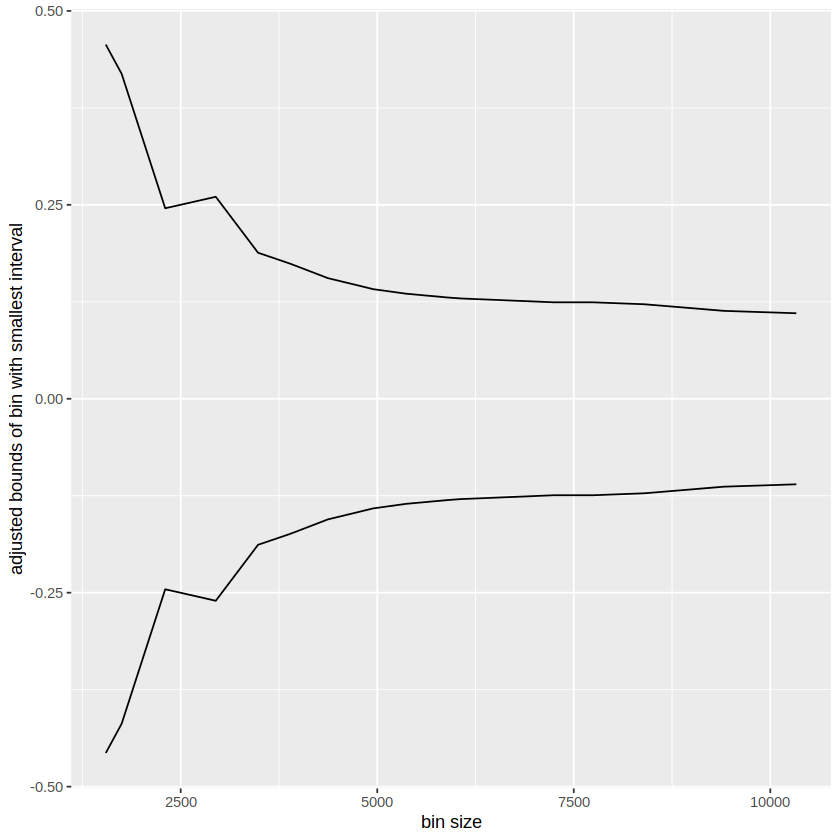

In [12]:
# plot results
df_bins %>% ggplot(aes(x=size,y= lb_adjusted)) + geom_line() + geom_line(aes(x=size,y=ub_adjusted)) +labs(y='adjusted bounds of bin with smallest interval',x='bin size')

### Make groups based on covariates

In [13]:
# calculate ratio of squared residuals
df_results <- df_results %>% mutate(e_ratio = residuals_ff^2/residuals_judge^2)

In [14]:
# define train and test set
set.seed(1234)
ind <- sample(2, nrow(df_results), replace = T, prob = c(0.8, 0.2))
train <- df_results[ind == 1,]
test <- df_results[ind == 2,]

In [15]:
# get other potential control variables?
controls <-grep("^n_", names(df), value = TRUE)

e_ratio ~ fe_year_x_d_1 + fe_year_x_d_2 + fe_year_x_d_3 + fe_year_x_d_4 + 
    fe_year_x_d_5 + fe_year_x_d_6 + fe_year_x_d_7 + fe_year_x_d_8 + 
    fe_year_x_d_9 + fe_year_x_d_10 + fe_year_x_d_11 + fe_year_x_d_12 + 
    fe_year_x_d_13 + fe_year_x_d_14 + fe_year_x_d_15 + fe_year_x_d_16 + 
    fe_year_x_d_17 + fe_year_x_d_18 + fe_year_x_d_19 + fe_year_x_d_20 + 
    fe_year_x_d_21 + fe_year_x_d_22 + fe_year_x_d_23 + fe_year_x_d_24 + 
    fe_year_x_d_25 + fe_year_x_d_26 + fe_year_x_d_27 + fe_year_x_d_28 + 
    fe_year_x_d_29 + fe_year_x_d_30 + fe_year_x_d_31 + fe_year_x_d_32 + 
    fe_year_x_d_33 + fe_year_x_d_34 + fe_year_x_d_35 + fe_year_x_d_36 + 
    fe_month_x__1 + fe_month_x__2 + fe_month_x__3 + fe_month_x__4 + 
    fe_month_x__5 + fe_month_x__6 + fe_month_x__7 + fe_month_x__8 + 
    fe_month_x__9 + fe_month_x__10 + fe_month_x__11 + fe_month_x__12 + 
    fe_month_x__13 + fe_month_x__14 + fe_month_x__15 + fe_month_x__16 + 
    fe_month_x__17 + fe_month_x__18 + fe_month_x__19 + fe_month

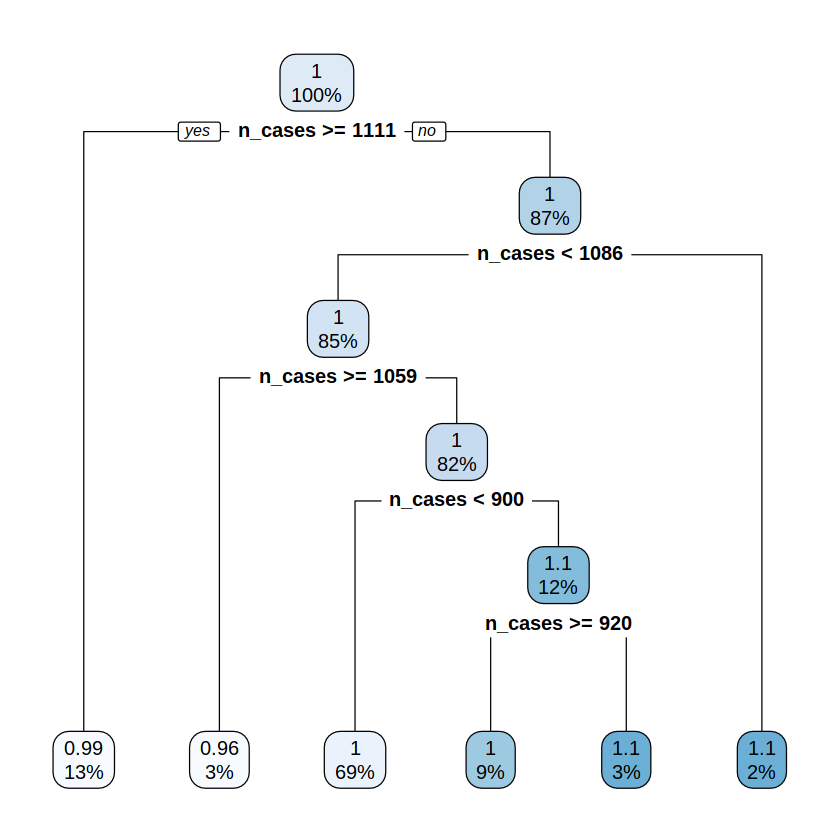

In [16]:
#Tree Classification
tree_formula <- as.formula(paste0('e_ratio~',paste(x_timeplace, collapse = " + "),'+',paste(controls, collapse = " + ")))
print(tree_formula)
tree <- rpart(tree_formula, data = train, minbucket=1000)
rpart.plot(tree)

In [17]:
# get grouping from tree
df_tree <- df_results
df_tree <- df_tree %>% mutate(id = rownames(df_results))
df_tree <- df_tree %>% left_join(as.data.frame(tree$where) %>% mutate(id = rownames(as.data.frame(tree$where))), 
                                       by='id')
df_tree <- df_tree %>% left_join(tree$frame %>% mutate(id = seq(1:nrow(tree$frame))), by=c('tree$where'='id'))

In [18]:
df_groups <- estimate_bounds(df_tree, treatment_var='bail_met', outcome_var='any_guilty', controls=x_timeplace,grouping=df_tree$`tree$where`)

Error encountered-regression singular



In [19]:
df_groups

effect_adjusted,lb_adjusted,ub_adjusted,effect_observed,lb_observed,ub_observed,se_observed,df_observed,confounder_exposure_r2,confounder_outcome_r2,group,size
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>
-1.942890e-16,-0.11165996,0.11165996,-0.2262604,-0.2462194,-0.2063015,0.010182009,9436,0.9681011,0.0017243196,2,9517
-5.551115e-17,-0.23172811,0.23172811,-0.1778229,-0.2165232,-0.1391226,0.019735708,2465,0.9721236,0.0009444262,5,2537
-1.387779e-16,-0.04967566,0.04967566,-0.2377451,-0.2463243,-0.2291658,0.004377157,52370,0.9702237,0.0017288376,7,52451
-8.326673e-17,-0.15950401,0.15950401,-0.2354245,-0.2590864,-0.2117627,0.012070509,7004,0.9780171,0.0012208025,9,7085
0.000000e+00,-0.21866204,0.21866204,-0.2470025,-0.2919730,-0.2020319,0.022931387,2107,0.9577857,0.0024269961,10,2172
2.775558e-16,-0.32710114,0.32710114,-0.2398655,-0.2881731,-0.1915578,0.024629781,1712,0.9782036,0.0012344289,11,1754


# Ramadan fasting increases leniency in judges from Pakistan and India
Link to paper: https://www.nature.com/articles/s41562-023-01547-3

Link to data:https://www.dropbox.com/scl/fi/gzsjvmf2bt98eclpk6pld/replication_files.rar?rlkey=j647zqvp20higy06nc1d540e0&e=1&dl=0

## Estimate Confounder Bounds based on First Stage R2


In [20]:
# read in data for Pakistan courts
df <- read_dta('replication_files/Input/indian_courts_acq.dta')
head(df)

SDCC,Muslim,start_date,end_date,state_code,archive,court_name,date_of_decision,decision_year,date_of_filing,⋯,pet_name,res_name,defendant_name,pet_name_hc,res_name_hc,pet_adv,pet_adv_hc,res_adv,res_adv_hc,judge_id
<dbl>,<dbl>,<date>,<date>,<chr>,<chr>,<chr>,<date>,<dbl>,<date>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1359312,0,2016-05-07,2017-05-08,13,Y,Chief Judicial Magistrate,2017-02-11,2017,2016-12-11,⋯,NA,NA,1,NA,NA,NA,NA,NA,NA,12906
132329,0,2015-10-20,2017-06-02,13,Y,Chief Judicial Magistrate,2016-11-12,2016,2000-11-21,⋯,1981301,NA,1,NA,NA,NA,NA,NA,NA,17054
1359312,0,2016-05-07,2017-05-08,13,Y,Chief Judicial Magistrate,2017-02-11,2017,2016-12-11,⋯,NA,NA,1,NA,NA,NA,NA,NA,NA,12906
1359312,0,2016-05-07,2017-05-08,13,Y,Chief Judicial Magistrate,2017-02-11,2017,2016-12-11,⋯,NA,NA,1,NA,NA,NA,NA,NA,NA,12906
132325,0,2015-04-16,2017-08-17,13,Y,Chief Judicial Magistrate,2017-07-08,2017,2002-11-28,⋯,723956,NA,1,NA,NA,NA,NA,NA,NA,9014
1359312,0,2016-05-07,2017-05-08,13,Y,Chief Judicial Magistrate,2017-02-11,2017,2016-12-11,⋯,NA,NA,1,NA,NA,NA,NA,NA,NA,12906


In [21]:
# remove NA from strict acquittal
df <-  df %>% drop_na(strict_acquittal)
dim(df)

[1] 372089    119

In [22]:
# specify covariates as from the original paper
controls <- c('Judgments', 'Criminal_Miscelleneous', 'Session_Judge', 'Rape', 'Assault', 'Robbery', 'Children_Sexual_Assault', 'Kidnapping', 'Fraud', 'Theft')
other_covars <- c('RamadanXHours', 'Daylight_Hours', 'Ramadan')
ff <- c('district_id', 'decision_year', 'decision_month', 'decision_week', 'decision_day')

### Estimate first stage with only time fixed effects

In [23]:
# fit model only with non-judge related fixed effects
reg_formula_ff <- as.formula(paste0('Acquittal~1+',paste(controls,collapse='+'),'+',
                                 paste(other_covars, collapse='+'),' + ',
                                            paste(ff, collapse='+')))
reg <- lm(reg_formula_ff, df)
summary(reg)


Call:
lm(formula = reg_formula_ff, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0036 -0.5190  0.3365  0.4470  0.9888 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.718e+01  8.558e-01 -20.072  < 2e-16 ***
Judgments                7.050e-02  5.394e-03  13.070  < 2e-16 ***
Criminal_Miscelleneous  -3.407e-01  4.073e-03 -83.648  < 2e-16 ***
Session_Judge            2.227e-02  2.401e-03   9.274  < 2e-16 ***
Rape                     1.153e-01  1.444e-02   7.989 1.37e-15 ***
Assault                  3.312e-01  1.040e-01   3.185 0.001449 ** 
Robbery                  2.868e-02  1.037e-02   2.766 0.005669 ** 
Children_Sexual_Assault  2.165e-02  1.886e-02   1.148 0.251042    
Kidnapping               1.764e-01  1.628e-02  10.837  < 2e-16 ***
Fraud                    2.353e-01  8.905e-02   2.642 0.008243 ** 
Theft                    1.413e-01  4.156e-02   3.400 0.000674 ***
RamadanXHours           -1.924e-01  9.79

In [24]:
# save predictions based on ff model
df_results <- cbind(df,predict_ff =predict(reg), residuals_ff = summary(reg)$residuals)

### Estimate First Stage with Time Fixed Effects + Judge Random Effects

In [25]:
# fit model including judge random effects
reg_formula_judge <- as.formula(paste0('Acquittal~1+',paste(controls,collapse='+'),'+',
                                 paste(other_covars, collapse='+'),' + ',
                                            paste(ff, collapse='+'), ' +(1|judge_id)'))
reg_judge <- lmer(reg_formula_judge, df)
summary(reg_judge)


Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: reg_formula_judge
   Data: df

REML criterion at convergence: 332445.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8762 -0.4285  0.0647  0.6200  3.1644 

Random effects:
 Groups   Name        Variance Std.Dev.
 judge_id (Intercept) 0.09032  0.3005  
 Residual             0.13740  0.3707  
Number of obs: 372089, groups:  judge_id, 7668

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             -6.928e+00  1.538e+00  1.804e+05  -4.503 6.69e-06 ***
Judgments               -2.754e-03  5.367e-03  3.257e+05  -0.513  0.60784    
Criminal_Miscelleneous  -7.084e-02  5.749e-03  1.884e+05 -12.323  < 2e-16 ***
Session_Judge            1.704e-02  8.979e-03  7.479e+03   1.898  0.05771 .  
Rape                     2.606e-02  1.176e-02  3.720e+05   2.215  0.02673 *  
Assault                  1.062e-01  7.951e-02  3.652e+05   1.335

In [26]:
# get residuals & predictions
df_results <- cbind(df_results,predict_judge = predict(reg_judge), residuals_judge= predict(reg_judge)-df$Acquittal, true= df$Acquittal)

### Get Bounds for different bins according to R2 in first stage

In [38]:
# estimate for different bin sizes - always keep the data for 'best performing bin' per size
df_bins <- data.frame()
for (i in c(seq(5000,10000,500),seq(10000,300000,10000))){
    out <- estimate_bounds(df_results, treatment_var='Acquittal', outcome_var='recidivism',controls=c(controls,other_covars,ff), bin_size=i)
    out <- out %>% mutate(diff = abs(lb_adjusted-ub_adjusted)) %>% filter(diff==min(diff))
    #print(out)
    df_bins <- rbind(df_bins,out)
    
}

`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'grouping', 'threshold_lower'. You can
override usin

In [39]:
df_bins

effect_adjusted,lb_adjusted,ub_adjusted,effect_observed,lb_observed,ub_observed,se_observed,df_observed,confounder_exposure_r2,confounder_outcome_r2,group,size,diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<int>,<dbl>
0.000000e+00,-0.032162694,0.032162694,-0.2268586,-0.2521926,-0.2015247,0.012923373,6715,0.4189599,0.06364240,"(0.488,0.491]",6819,0.064325387
0.000000e+00,-0.030888264,0.030888264,-0.2062939,-0.2325442,-0.1800436,0.013390312,5496,0.3385726,0.08436742,"(0.412,0.425]",5560,0.061776527
0.000000e+00,-0.028845761,0.028845761,-0.2479194,-0.2706582,-0.2251806,0.011599537,6694,0.4338529,0.08905141,"(0.448,0.456]",6805,0.057691522
2.775558e-17,-0.028977588,0.028977588,-0.2326602,-0.2569208,-0.2083996,0.012375761,6427,0.3657933,0.09534267,"(0.402,0.422]",6503,0.057955175
-2.775558e-17,-0.027864162,0.027864162,-0.2127007,-0.2360298,-0.1893716,0.011900753,6955,0.3569344,0.08274823,"(0.409,0.427]",7036,0.055728325
0.000000e+00,-0.027069749,0.027069749,-0.1871375,-0.2104513,-0.1638237,0.011893188,7949,0.3096677,0.06943442,"(0.414,0.428]",8026,0.054139497
2.775558e-17,-0.027004476,0.027004476,-0.1908894,-0.2141009,-0.1676778,0.011841039,7963,0.3138207,0.07136138,"(0.419,0.431]",8041,0.054008951
-2.775558e-17,-0.025288211,0.025288211,-0.2235693,-0.2445659,-0.2025727,0.010711197,8412,0.3710586,0.08778428,"(0.382,0.421]",8533,0.050576422
0.000000e+00,-0.023992389,0.023992389,-0.2345355,-0.2546954,-0.2143757,0.010284477,9184,0.3638071,0.09902358,"(0.394,0.425]",9299,0.047984778


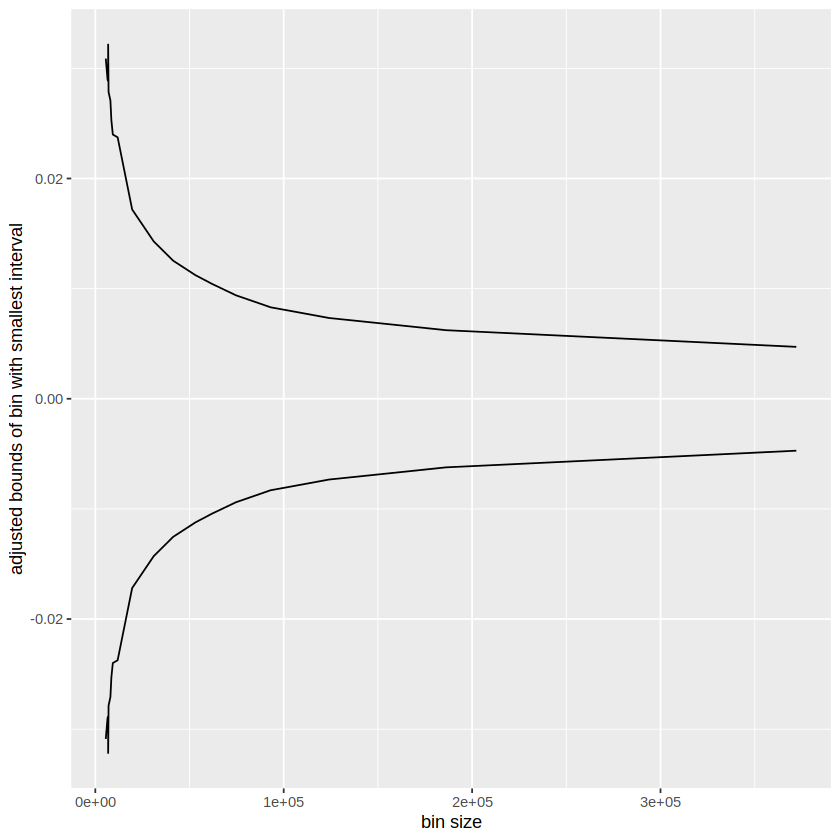

In [40]:
# plot results
df_bins %>% ggplot(aes(x=size,y= lb_adjusted)) + geom_line() + geom_line(aes(x=size,y=ub_adjusted)) +labs(y='adjusted bounds of bin with smallest interval',x='bin size')

### Make groups based on covariates

In [41]:
# calculate ratio of squared residuals
df_results <- df_results %>% mutate(e_ratio = residuals_ff^2/residuals_judge^2)

In [42]:
# define train and test set
set.seed(1234)
ind <- sample(2, nrow(df_results), replace = T, prob = c(0.8, 0.2))
train <- df_results[ind == 1,]
test <- df_results[ind == 2,]

In [43]:
tree_formula <- as.formula(paste0('e_ratio~',paste(controls,collapse='+'),' + ',paste(other_covars,collapse='+'),' + ',paste(ff,collapse='+')))


e_ratio ~ Judgments + Criminal_Miscelleneous + Session_Judge + 
    Rape + Assault + Robbery + Children_Sexual_Assault + Kidnapping + 
    Fraud + Theft + RamadanXHours + Daylight_Hours + Ramadan + 
    district_id + decision_year + decision_month + decision_week + 
    decision_day


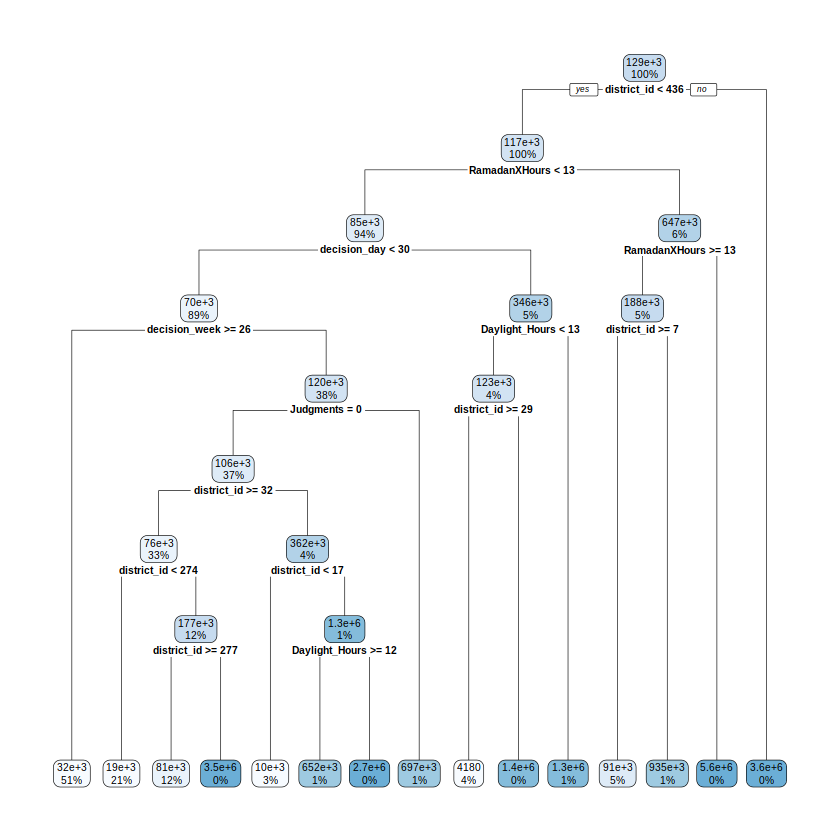

In [45]:
#Tree Classification
print(tree_formula)
tree <- rpart(tree_formula, data = train, cp=0.00001, minbucket=1000)
rpart.plot(tree)

In [46]:
# get grouping from tree
df_tree <- df_results
df_tree <- df_tree %>% mutate(id = rownames(df_results))
df_tree <- df_tree %>% left_join(as.data.frame(tree$where) %>% mutate(id = rownames(as.data.frame(tree$where))), 
                                       by='id')
df_tree <- df_tree %>% left_join(tree$frame %>% mutate(id = seq(1:nrow(tree$frame))), by=c('tree$where'='id'))

In [50]:
df_groups <- estimate_bounds(df_tree, treatment_var='Acquittal', outcome_var='recidivism', controls=c(controls,other_covars,ff),grouping=df_tree$`tree$where`)

Error encountered-regression singular



In [51]:
df_groups

effect_adjusted,lb_adjusted,ub_adjusted,effect_observed,lb_observed,ub_observed,se_observed,df_observed,confounder_exposure_r2,confounder_outcome_r2,group,size
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>
2.775558e-17,-0.00715357,0.00715357,-0.17971534,-0.18473752,-0.174693156,0.002562364,147200,0.5221902,0.0305778793,5,150848
-2.775558e-17,-0.01283281,0.01283281,-0.12839007,-0.13628785,-0.120492289,0.004029477,62713,0.6249120,0.0097167772,9,63834
0.000000e+00,-0.01647374,0.01647374,-0.17268457,-0.18357338,-0.161795755,0.005555416,33120,0.5726059,0.0217749018,11,34533
0.000000e+00,-0.09872328,0.09872328,-0.20506189,-0.27705828,-0.133065500,0.036686627,948,0.4861434,0.0348356165,12,1005
-5.551115e-17,-0.02977866,0.02977866,-0.24184165,-0.26472860,-0.218954699,0.011675519,8263,0.4471564,0.0641970359,14,8463
1.387779e-17,-0.08448453,0.08448453,-0.09899959,-0.16105872,-0.036940463,0.031644625,2041,0.4631547,0.0055583632,16,2114
1.387779e-17,-0.13759650,0.13759650,-0.11658296,-0.20071850,-0.032447424,0.042873905,977,0.6274088,0.0044943983,17,1012
-6.938894e-18,-0.07548405,0.07548405,-0.04065785,-0.08561866,0.004302960,0.022927584,2309,0.6453330,0.0007484886,18,2689
1.387779e-17,-0.03316508,0.03316508,-0.07956103,-0.09867201,-0.060450054,0.009749622,11167,0.6689002,0.0029517964,21,11526
